# Grounded co-planar waveguide with via fence

Co-planar waveguide (CPWs) transmission lines offer many advantages, including better EM shielding, ease of fabrication, and lower radiation loss when compared to microstrips. However, conventional CPWs can be susceptible to coupling to higher-order modes in nearby structures, thus introducing undesirable resonances that restrict the operating bandwidth of the CPW. In particular, at high frequencies, the side ground planes in a conventional CPW can support higher-order resonances that radiate similarly to a patch antenna.

One solution is to introduce via fences on either side of the signal line. This reduces the transverse electrical size of the CPW and "pushes" the resonances out beyond the design bandwidth of the CPW. It also provides the added benefit of better shielding from EM interference.

In this notebook, we will simulate some of the designs investigated in this paper:

* Sain, Arghya, and Kathleen L. Melde, "Impact of ground via placement in grounded coplanar waveguide interconnects." IEEE Transactions on Components, Packaging and Manufacturing Technology 6.1 (2015): 136-144.

We begin by simulating a conventional CPW with a bottom ground plane to demonstrate the undesirable resonant effect. Then, we will compare it to a design with via fences. Finally, we will test a setup fabricated by Sain et al. in order to validate the simulation results. 

<center><img src="./img/gcpw_via_fence_render.png" width=540 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.microwave as mw
import tidy3d.plugins.smatrix as sm
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging_level = "ERROR"

## Building the simulation

### Key parameters and materials

The key parameters for this model are the operating frequency range, the geometry, and the material properties. These are defined below. 

<center><img src="./img/gcpw_via_fence_schematic.png" width=800 /></center>

In [2]:
# Frequency
f_min, f_max = (1e9, 100e9)  # Frequency range (Hz)
f0 = (f_max + f_min) / 2  # Center frequency
freqs = np.linspace(f_min, f_max, 301)  # Sample frequency points
field_mon_freqs = np.linspace(f_min, f_max, 21)  # Frequency points for field monitor data

# CPW Geometry
len_inf = 1e5  # Effective infinity
ws = 177.8  # Signal strip width
wg = 1600  # Ground strip width
t = 17.78  # Conductor thickness
h = 101.6  # Substrate thickness
gg = 101.6  # Gap between signal and side ground
L = 6000  # CPW line length

# Via geometry
vr = 76.2  # Via radius
vp = 287.3  # Via pitch (longitudinal spacing)
vl = 400  # Via transverse spacing (from center of signal strip)
es = 127  # Distance from first/last via to CPW start/end

# Overall simulation size and center
sim_size = (5600, 1000, 7500)
sim_center = (0, 500 - h - t, 0)

Both the substrate and metal are assumed to have constant loss over the frequency range. The materials used for the simulation are defined below. 

In [3]:
# Material properties
cond = 58  # Metal conductivity in S/um
eps = 3.5  # Relative permittivity, substrate
losstan = 0.002  # Loss tangent, substrate

In [4]:
med_sub = FastDispersionFitter.constant_loss_tangent_model(
    eps, losstan, (f_min, f_max), tolerance_rms=3e-4
)
med_metal = td.LossyMetalMedium(conductivity=cond, frequency_range=(f_min, f_max), name="Metal")
med_air = td.Medium(permittivity=1.0, name="Air")

Output()

### Geometry construction

We start by creating all the planar structures (substrate and metal strips). The ground plane and substrate are assumed to be infinite in width and length.

In [5]:
# Substrate
str_sub = td.Structure(
    geometry=td.Box(center=(0, -h / 2, 0), size=(len_inf, h, len_inf)), medium=med_sub
)

# Signal strip
str_sig = td.Structure(geometry=td.Box(center=(0, t / 2, 0), size=(ws, t, L)), medium=med_metal)

# Side and bottom grounds
str_gnd1 = td.Structure(
    geometry=td.Box(center=((ws + wg) / 2 + gg, t / 2, 0), size=(wg, t, L)), medium=med_metal
)
str_gnd2 = td.Structure(
    geometry=td.Box(center=(-(ws + wg) / 2 - gg, t / 2, 0), size=(wg, t, L)), medium=med_metal
)
str_gnd3 = td.Structure(
    geometry=td.Box(center=(0, -h - t / 2, 0), size=(len_inf, t, len_inf)), medium=med_metal
)

We define a reusable function to create the via structure at a given (x, z) position. 

In [6]:
def create_via(xpos, zpos):
    """Create one via structure at given x and z positions"""
    via_structure = td.Structure(
        geometry=td.Cylinder(center=(xpos, -h / 2, zpos), radius=vr, length=h, axis=1),
        medium=med_metal,
    )

    return via_structure

Then, we loop over all x- and z-positions to create the via fence. 

In [7]:
# create vias
str_via_fence = []
for zpos in np.arange(-L / 2 + es, L / 2 - es + 10, vp):
    for xpos in [-vl, vl]:
        str_via_fence += [create_via(xpos, zpos)]

We consolidate the structures into two lists, with and without the via fence. We will use these in two separate simulations later. 

In [8]:
# List of all structures (with and without via fence)
str_list_1 = [str_sub, str_gnd1, str_gnd2, str_gnd3, str_sig]
str_list_2 = [str_sub, str_gnd1, str_gnd2, str_gnd3, str_sig] + str_via_fence

### Grid

We use the `LayerRefinementSpec` feature to automatically apply refinement to metal edges and corners. 

In [9]:
def create_layer_refinement_spec(structure_list):
    """Creates a LayerRefinementSpec using the bounding box of the given list of structures"""
    lr_spec = td.LayerRefinementSpec.from_structures(
        structures=structure_list,
        axis=1,
        min_steps_along_axis=1,
        bounds_snapping="bounds",  # snap grid to metal boundaries
        corner_refinement=td.GridRefinement(
            dl=t, num_cells=2
        ),  # snap to corners and apply added refinement
    )

    return lr_spec


# Apply layer refinement to top and bottom metal planes
lr_spec_1 = create_layer_refinement_spec([str_sig, str_gnd1, str_gnd2])
lr_spec_2 = create_layer_refinement_spec([str_gnd3])

For the rest of the model, we define the grid size using the `min_steps_per_sim_size` parameter since the simulation is largely sub-wavelength. 

In [10]:
# Define overall grid specification
grid_spec = td.GridSpec.auto(
    min_steps_per_sim_size=100,
    wavelength=td.C_0 / f_max,
    layer_refinement_specs=[lr_spec_1, lr_spec_2],
)

### Boundaries

We use the Perfectly Matched Layer (PML) boundary condition on all sides except the bottom. For the bottom boundary, we use the PEC condition for simplicity, since it is adjacent to the infinite bottom ground plane. 

In [11]:
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary(plus=td.PML(), minus=td.PECBoundary()),
    z=td.Boundary.pml(),
)

### Monitors

We define two field monitors for visualization purposes. One is in the longitudinal substrate plane, while the other is along the transverse plane halfway down the CPW.

In [12]:
field_mon_1 = td.FieldMonitor(
    center=(0, -h / 2, 0),
    size=(td.inf, 0, td.inf),
    freqs=field_mon_freqs,
    name="field (substrate plane)",
)

field_mon_2 = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=field_mon_freqs, name="transverse field"
)

### Ports

In general, we have a choice of using `WavePort` or `LumpedPort` to excite the structure. Because we are probing the resonances of this finite length CPW, it makes more sense to use the `LumpedPort`. 

The lumped port is positioned in the gap between the signal strip and side ground planes, with the port voltage axis aligned along the x-direction. The design impedance of the CPW is around 50 ohms, so each lumped port should be 100 ohms. 

In [13]:
LP_len = 50  # Lumped port length

LP1 = sm.LumpedPort(
    center=((ws + gg) / 2, t / 2, -L / 2 + LP_len / 2),
    size=(gg, 0, LP_len),
    name="LP1",
    impedance=100,  # in Ohms
    voltage_axis=0,  # 0 = x-axis
)

LP2 = LP1.updated_copy(name="LP2", center=((ws + gg) / 2, t / 2, L / 2 - LP_len / 2))

### Simulation and TerminalComponentModeler

The `Simulation` object contains all of the previously defined specifications. The first simulation implements the conventional CPW layout without via fences. 

In [14]:
sim_without_via_fence = td.Simulation(
    size=sim_size,
    center=sim_center,
    medium=med_air,  # background medium is air/vacuum
    grid_spec=grid_spec,
    boundary_spec=boundary_spec,
    structures=str_list_1,
    monitors=[field_mon_1, field_mon_2],
    run_time=3.5e-9,  # simulation run time
    symmetry=(1, 0, 0),  # odd symmetry in x-direction
    plot_length_units="mm",  # set plot units to mm
)

The `TerminalComponentModeler` is a wrapper class that conducts a port sweep on the simulation. The lumped ports are set here. 

In [15]:
tcm_without_via_fence = sm.TerminalComponentModeler(
    simulation=sim_without_via_fence,  # simulation, previously defined
    ports=[LP1, LP2],  # lumped ports, previously defined
    freqs=freqs,  # S-parameter frequency points
)

### Visualization

Before executing the simulation, we plot the structure and grid along various planes to check that they are adequately set up and resolved. 

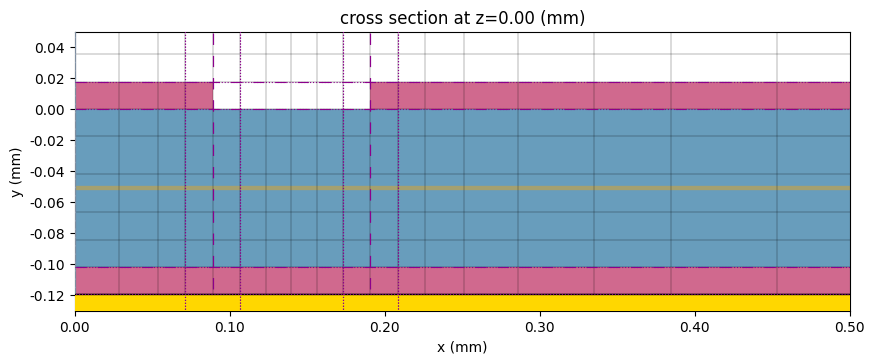

In [16]:
# Inspect transverse grid near CPW gap
fig, ax = plt.subplots(figsize=(10, 5))
sim_without_via_fence.plot(z=1, ax=ax)
sim_without_via_fence.plot_grid(z=1, ax=ax, hlim=(0, 500), vlim=(-130, 50))
plt.show()

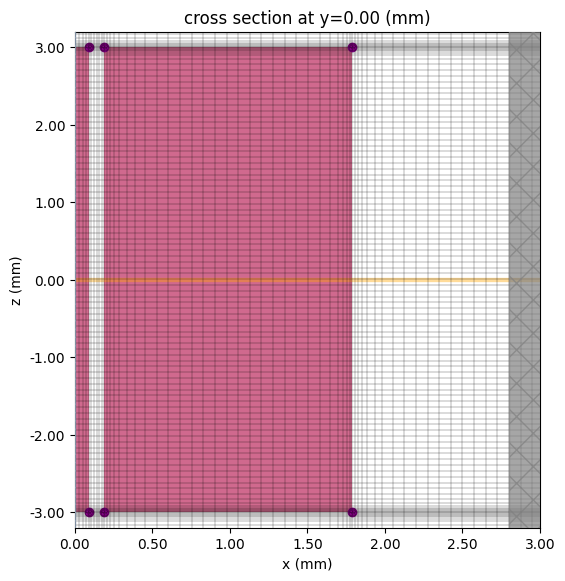

In [17]:
# Inspect longitudinal grid
fig, ax = plt.subplots(figsize=(6, 8))
sim_without_via_fence.plot(y=1, ax=ax)
sim_without_via_fence.plot_grid(y=1, ax=ax, hlim=(0, 3000), vlim=(-L / 2 - 200, L / 2 + 200))
ax.set_aspect(0.5)
plt.show()

We can also use the built-in 3D viewer. 

In [18]:
sim_without_via_fence.plot_3d()

The lumped ports can be viewed using the `plot_sim()` method of the TCM. 

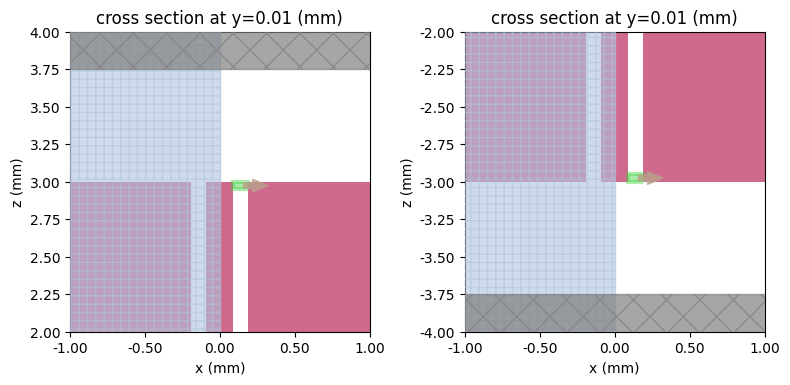

In [19]:
# Plot lumped ports
fig, ax = plt.subplots(1, 2, figsize=(8, 6), tight_layout=True)
tcm_without_via_fence.plot_sim(y=t / 2, ax=ax[0])
ax[0].set_xlim(-1000, 1000)
ax[0].set_ylim(L / 2 - 1000, L / 2 + 1000)
tcm_without_via_fence.plot_sim(y=t / 2, ax=ax[1])
ax[1].set_xlim(-1000, 1000)
ax[1].set_ylim(-L / 2 - 1000, -L / 2 + 1000)
plt.show()

## Conventional CPW with Lower Ground Plane

We execute the TCM to obtain the S-parameter matrix. 

In [20]:
tcm_data_without_via_fence = td.web.run(
    tcm_without_via_fence,
    task_name="GCPW no via fence",
    path="data/tcm_data_without_via_fence.hdf5",
)

11:33:31 EDT Created task 'GCPW no via fence' with resource_id                  
             'sid-5c7e9da9-94cc-4d06-9fb0-fe3a41a9c842' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=262848;https://tidy3d.simulation.cloud/rf?taskId=pa-e06e75b8-01af-4510-af2a-b58927e23a5c\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=499894;https://tidy3d.simulation.cloud/rf?taskId=pa-e06e75b8-01af-4510-af2a-b58927e23a5c\taskId]8;;\]8;id=262848;https://tidy3d.simulation.cloud/rf?taskId=pa-e06e75b8-01af-4510-af2a-b58927e23a5c\=]8;;\]8;id=807066;https://tidy3d.simulation.cloud/rf?taskId=pa-e06e75b8-01af-4510-af2a-b58927e23a5c\pa]8;;\]8;id=262848;https://tidy3d.simulation.cloud/rf?taskId=pa-e06e75b8-01af-4510-af2a-b58927e23a5c\-e06e75b8-01af-4510-af]8;;\
             ]8;id=262848;https://tidy3d.simulation.cloud/rf?taskId=pa-e06e75b8-01af-4510-af2a-b58927e23a5c\2a-b58927e23a5c']8;;\.

             Task folder: ]8;id=332223;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

11:33:33 EDT Child simulation subtasks are being uploaded to                    
             - LP1: rf-7e0b0152-3d9c-482b-8342-f6dddb766a55                     
             - LP2: rf-ee8ee565-e9e8-4ced-8ec1-83c402cd8427

11:33:34 EDT Validating batch...

             Maximum FlexCredit cost: 0.114. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Batch validation completed.

11:33:35 EDT Modeler Batch: GCPW no via fence (group                            
             pa-e06e75b8-01af-4510-af2a-b58927e23a5c)

Output()

11:34:42 EDT Postprocess completed.

Output()

11:34:45 EDT loading component modeler data from                                
             data/tcm_data_without_via_fence.hdf5

In [21]:
# Calculate s-matrix
s_matrix = tcm_data_without_via_fence.smatrix()

The S-parameters are extracted and S21 is plotted below. 

In [22]:
S11 = np.conjugate(s_matrix.data.sel(port_in="LP1", port_out="LP1"))
S21 = np.conjugate(s_matrix.data.sel(port_in="LP1", port_out="LP2"))
S11dB = 20 * np.log10(np.abs(S11))
S21dB = 20 * np.log10(np.abs(S21))

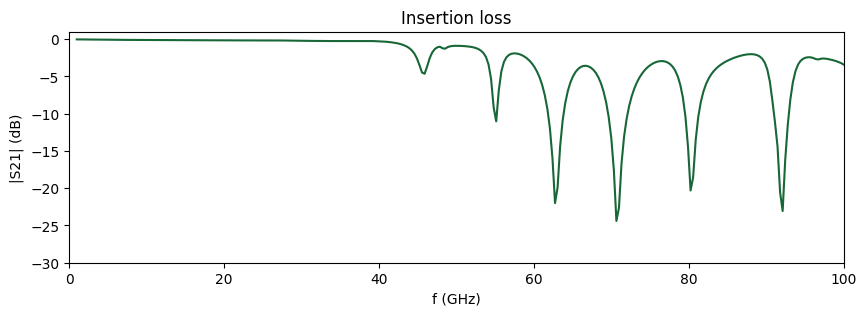

In [23]:
# Plotting S-parameters
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(freqs / 1e9, S21dB)
ax.set_xlim(0, 100)
ax.set_ylim(-30, 1)
ax.set_title("Insertion loss")
ax.set_ylabel("|S21| (dB)")
ax.set_xlabel("f (GHz)")
plt.show()

At frequencies above 40 GHz, higher-order resonances in the CPW limit its usable bandwidth. The resonant frequencies are partly determined by the width and length of the side ground planes. We visualize one such resonance near f=71 GHz below. 

In order to view the field monitor data, we load it from the dictionary object associated with the TCM data. 

In [24]:
# Load monitor data
sim_data_without_via_fence = tcm_data_without_via_fence.data["LP1"]

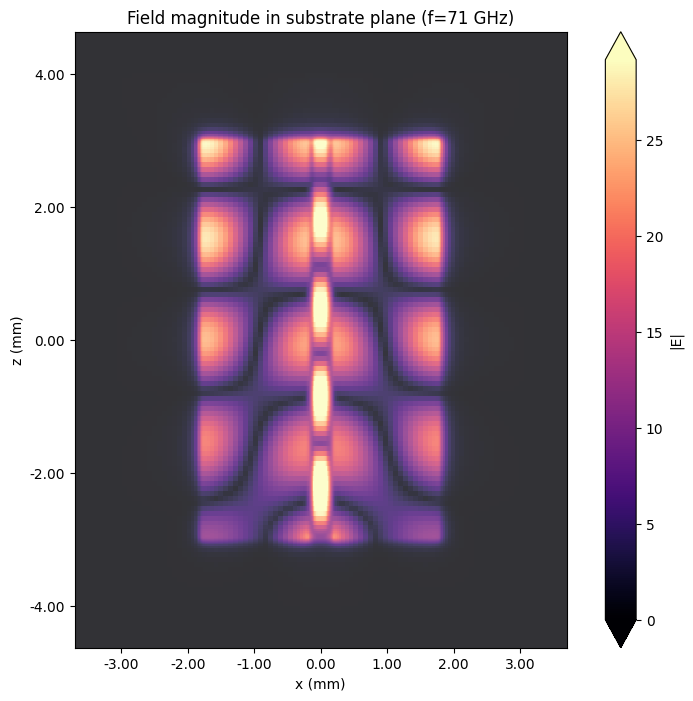

In [25]:
# Field plot
fig, ax = plt.subplots(figsize=(10, 8))
sim_without_via_fence.plot_structures(y=0, ax=ax, fill=False)
sim_data_without_via_fence.plot_field(
    "field (substrate plane)", field_name="E", val="abs", f=71e9, ax=ax, eps_alpha=0.2
)
ax.set_title("Field magnitude in substrate plane (f=71 GHz)")
plt.show()

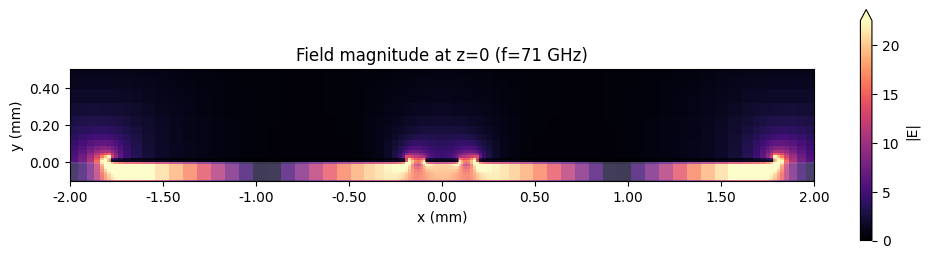

In [26]:
# Field plot
fig, ax = plt.subplots(figsize=(12, 3))
sim_without_via_fence.plot_structures(z=0, ax=ax, fill=False)
sim_data_without_via_fence.plot_field("transverse field", field_name="E", val="abs", f=71e9, ax=ax)
ax.set_title("Field magnitude at z=0 (f=71 GHz)")
ax.set_ylim(-100, 500)
ax.set_xlim(-2000, 2000)
plt.show()

The higher-order mode in the side ground planes is clearly visible from the field plots above. 

## Adding Via Fences

In order to restrict the higher-order modes, we will add via fences on both sides of the signal strip. 

We make use of the `updated_copy()` method to easily modify the structure list, without having to redefine from scratch the `Simulation` or `TerminalComponentModeler` objects. 

In [27]:
sim_via_fence = sim_without_via_fence.updated_copy(structures=str_list_2)
tcm_via_fence = tcm_without_via_fence.updated_copy(simulation=sim_via_fence)

Executing the simulation below. 

In [28]:
tcm_data_via_fence = td.web.run(
    tcm_via_fence, task_name="GCPW via fence", path="data/tcm_data_via_fence.hdf5"
)

11:35:38 EDT Created task 'GCPW via fence' with resource_id                     
             'sid-f396a1ea-7873-4806-be3f-8dbaf1f4e1b2' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=925441;https://tidy3d.simulation.cloud/rf?taskId=pa-ad883a0b-be3f-4155-81b9-65e26a559b72\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=473919;https://tidy3d.simulation.cloud/rf?taskId=pa-ad883a0b-be3f-4155-81b9-65e26a559b72\taskId]8;;\]8;id=925441;https://tidy3d.simulation.cloud/rf?taskId=pa-ad883a0b-be3f-4155-81b9-65e26a559b72\=]8;;\]8;id=889140;https://tidy3d.simulation.cloud/rf?taskId=pa-ad883a0b-be3f-4155-81b9-65e26a559b72\pa]8;;\]8;id=925441;https://tidy3d.simulation.cloud/rf?taskId=pa-ad883a0b-be3f-4155-81b9-65e26a559b72\-ad883a0b-be3f-4155-81]8;;\
             ]8;id=925441;https://tidy3d.simulation.cloud/rf?taskId=pa-ad883a0b-be3f-4155-81b9-65e26a559b72\b9-65e26a559b72']8;;\.

             Task folder: ]8;id=735788;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

11:35:40 EDT Child simulation subtasks are being uploaded to                    
             - LP1: rf-0cdbc6f9-7971-461d-9587-8fd105230368                     
             - LP2: rf-d403f00d-34ee-454f-871c-c87e150ad949

11:35:41 EDT Validating batch...

11:35:42 EDT Maximum FlexCredit cost: 0.143. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Batch validation completed.

11:35:43 EDT Modeler Batch: GCPW via fence (group                               
             pa-ad883a0b-be3f-4155-81b9-65e26a559b72)

Output()

11:36:56 EDT Postprocess completed.

Output()

11:36:59 EDT loading component modeler data from data/tcm_data_via_fence.hdf5

In [29]:
# Calculate s-matrix
s_matrix_vf = tcm_data_via_fence.smatrix()

Like before, we extract and plot the insertion loss. 

In [30]:
# Extracting S-parameters
S11_vf = np.conjugate(s_matrix_vf.data.sel(port_in="LP1", port_out="LP1"))
S21_vf = np.conjugate(s_matrix_vf.data.sel(port_in="LP1", port_out="LP2"))
S11dB_vf = 20 * np.log10(np.abs(S11_vf))
S21dB_vf = 20 * np.log10(np.abs(S21_vf))

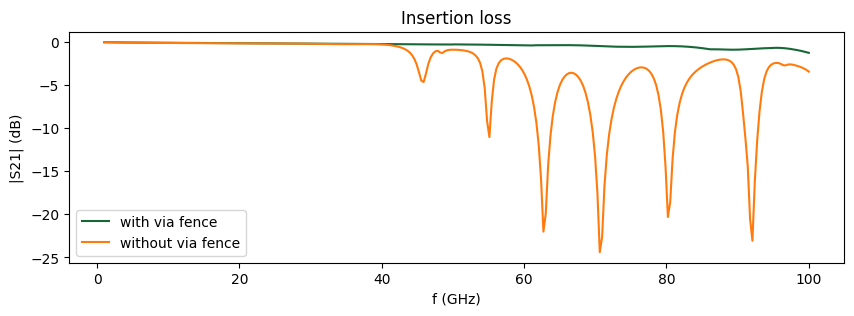

In [31]:
# Plotting S-parameters
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(freqs / 1e9, S21dB_vf, label="with via fence")
ax.plot(freqs / 1e9, S21dB, label="without via fence")
ax.set_title("Insertion loss")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("|S21| (dB)")
ax.legend()
plt.show()

The addition of the via fences has suppressed the higher-order resonances in the side ground planes. This allows the CPW to have a much wider operational bandwidth. Let's compare the fields at the same resonance point below. 

In [32]:
# Load monitor data
sim_data_via_fence = tcm_data_via_fence.data["LP1"]

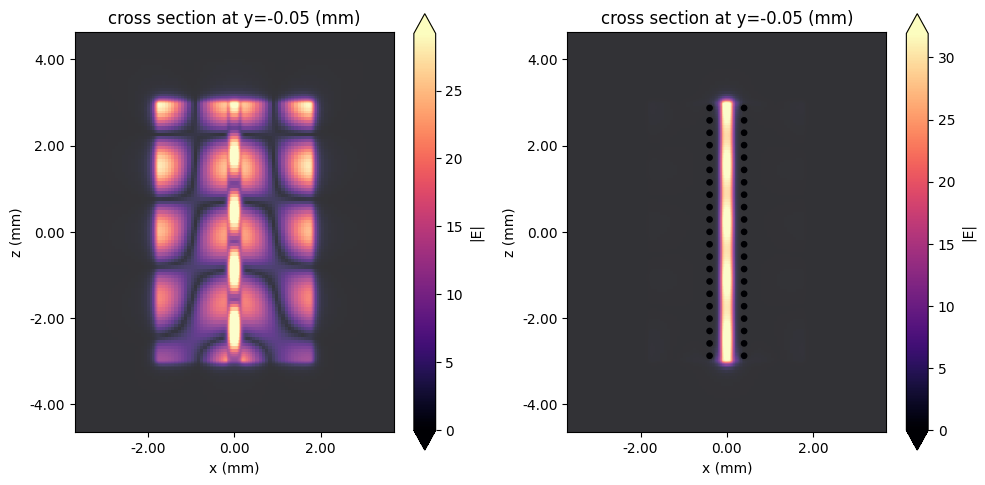

In [33]:
# Field plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
sim_data_without_via_fence.plot_field(
    "field (substrate plane)", field_name="E", val="abs", f=71e9, ax=ax[0], eps_alpha=0.2
)
sim_data_via_fence.plot_field(
    "field (substrate plane)", field_name="E", val="abs", f=71e9, ax=ax[1], eps_alpha=0.2
)
plt.show()

With the via fence, the field is very well confined to the region close to the signal line. 

## Experimental Validation

For validation, Sain et al. fabricated a design shown in Fig. 9 in the reference paper. They used HFSS, a commercial FEM tool, to compare with the measured data. In this section, we will do the same with our RF solver. 

In [34]:
# Geometry parameters for experimental setup
wg2 = 1200
vl2 = 1212.7
vp2 = 508
es2 = 460

# Create new side ground planes
str_gnd4 = td.Structure(
    geometry=td.Box(center=((ws + wg2) / 2 + gg, t / 2, 0), size=(wg2, t, L)), medium=med_metal
)
str_gnd5 = td.Structure(
    geometry=td.Box(center=(-(ws + wg2) / 2 - gg, t / 2, 0), size=(wg2, t, L)), medium=med_metal
)

# Create via fence
str_via_fence_2 = []
for zpos in np.arange(-L / 2 + es2, L / 2 - es2 + 10, vp2):
    for xpos in [-vl2, vl2]:
        str_via_fence_2 += [create_via(xpos, zpos)]

# Structure list
str_list_3 = [str_sub, str_gnd4, str_gnd5, str_gnd3, str_sig] + str_via_fence_2

In [35]:
# Update simulation and TCM
freqs_exp = np.linspace(1e9, 40e9, 301)
sim_exp = sim_without_via_fence.updated_copy(
    structures=str_list_3,
    monitors=[],
)
tcm_exp = tcm_without_via_fence.updated_copy(simulation=sim_exp, freqs=freqs_exp)

Let's example the setup in 3D.

In [36]:
sim_exp.plot_3d()

We run the simulation below. 

In [38]:
tcm_data_exp = td.web.run(tcm_exp, task_name="GCPW experiment", path="data/tcm_data_exp.hdf5")

11:37:16 EDT Created task 'GCPW experiment' with resource_id                    
             'sid-a9343bb6-85f0-4431-94df-05845b86bb96' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=12002;https://tidy3d.simulation.cloud/rf?taskId=pa-9c798957-1d87-43a3-8148-7016bada675d\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=668909;https://tidy3d.simulation.cloud/rf?taskId=pa-9c798957-1d87-43a3-8148-7016bada675d\taskId]8;;\]8;id=12002;https://tidy3d.simulation.cloud/rf?taskId=pa-9c798957-1d87-43a3-8148-7016bada675d\=]8;;\]8;id=726292;https://tidy3d.simulation.cloud/rf?taskId=pa-9c798957-1d87-43a3-8148-7016bada675d\pa]8;;\]8;id=12002;https://tidy3d.simulation.cloud/rf?taskId=pa-9c798957-1d87-43a3-8148-7016bada675d\-9c798957-1d87-43a3-81]8;;\
             ]8;id=12002;https://tidy3d.simulation.cloud/rf?taskId=pa-9c798957-1d87-43a3-8148-7016bada675d\48-7016bada675d']8;;\.

             Task folder: ]8;id=994933;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

11:37:18 EDT Child simulation subtasks are being uploaded to                    
             - LP1: rf-1b56cc73-ce70-4f48-985f-4ccf4c1b8080                     
             - LP2: rf-79c2254e-a8e3-432f-b2a7-f2a9b6ac3863

             Validating batch...

11:37:19 EDT Maximum FlexCredit cost: 0.129. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Batch validation completed.

11:37:20 EDT Modeler Batch: GCPW experiment (group                              
             pa-9c798957-1d87-43a3-8148-7016bada675d)

Output()

11:38:03 EDT Postprocess completed.

Output()

11:38:04 EDT loading component modeler data from data/tcm_data_exp.hdf5

In [39]:
# Calculate s-matrix
s_matrix_exp = tcm_data_exp.smatrix()

In [40]:
# Extract S-parameters
S11_exp = np.conjugate(s_matrix_exp.data.sel(port_in="LP1", port_out="LP1"))
S21_exp = np.conjugate(s_matrix_exp.data.sel(port_in="LP1", port_out="LP2"))
S11dB_exp = 20 * np.log10(np.abs(S11_exp))
S21dB_exp = 20 * np.log10(np.abs(S21_exp))

In [41]:
# Import reference data
freqs_sain_measured, S21dB_sain_measured = np.loadtxt(
    "./misc/gcpw_sain_experimental.csv", delimiter=",", unpack=True, skiprows=1
)
freqs_sain_hfss, S21dB_sain_hfss = np.loadtxt(
    "./misc/gcpw_sain_simulated.csv", delimiter=",", unpack=True, skiprows=1
)

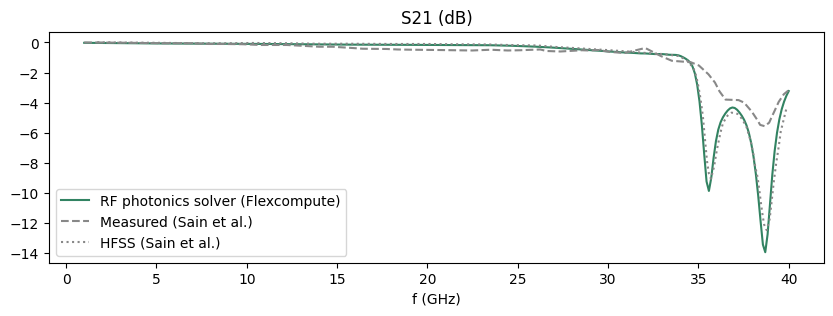

In [42]:
# Plot S21
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(
    freqs_exp / 1e9,
    20 * np.log10(np.abs(S21_exp)),
    label="RF photonics solver (Flexcompute)",
    color="#328362",
)
ax.plot(
    freqs_sain_measured, S21dB_sain_measured, "--", color="#888888", label="Measured (Sain et al.)"
)
ax.plot(freqs_sain_hfss, S21dB_sain_hfss, ":", color="#888888", label="HFSS (Sain et al.)")
ax.set_title("S21 (dB)")
ax.set_xlabel("f (GHz)")
ax.legend()
plt.show()

We observe a good match with the data from Sain et al. 

Remaining discrepancy with the measured data, as noted by Sain et al., can be attributed to metal surface roughness as well as deviations in the fabrication measurements. 

## Reference

[1] Sain, Arghya, and Kathleen L. Melde, "Impact of ground via placement in grounded coplanar waveguide interconnects." IEEE Transactions on Components, Packaging and Manufacturing Technology 6.1 (2015): 136-144.